# Catastrophic Forgetting

install dependencies:

In [ ]:
!pip install avalanche-lib==0.5.0  pytorchcv==0.0.67

tested with:
- python 3.10
- avalanche 0.5.0

In [1]:
import torch
import avalanche
import torchvision
import matplotlib.pyplot as plt

# Dataset
We start by loading CIFAR10. Unlike the previous exercises, now we split it into two datasets of 5 classes each.

In [2]:
from avalanche.benchmarks import SplitCIFAR10
from avalanche.benchmarks import with_task_labels

benchmark = SplitCIFAR10(n_experiences=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
e0, e1 = benchmark.train_stream
e0.classes_in_this_experience, e1.classes_in_this_experience

([0, 1, 6, 8, 9], [2, 3, 4, 5, 7])

In [4]:
e0.task_label, e1.task_label

(0, 0)

# Training - Naive Finetuning
We import the model directly from Avalanche.

Naive finetuning is the standard SGD algorithm applied sequentially to each experience. We don't freeze any parameter.

In [6]:
def train(exp, model, optimizer, criterion):
    model.train()
    train_data = exp.dataset
    train_data = train_data.train()

    for ep in range(1):  # increase epochs if necessary
        dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
        pbar = tqdm(dataloader)
        for (x, y, _) in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()   
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Loss: {loss.item():0.4f}")

In [7]:
from tqdm import tqdm
from avalanche.models import SlimResNet18
from torch.utils.data import DataLoader

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# We train sequentially on each experience of the stream
for exp in benchmark.train_stream:
    train(exp, model, optimizer, criterion)

Loss: 0.8959: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


# Evaluation

In [8]:
def eval(exp, model):
    model = model.eval()
    valid_data = exp.dataset
    valid_data = valid_data.eval()
    dataloader = DataLoader(valid_data, batch_size=32)
    pbar = tqdm(dataloader)
    correct, tot = 0, 0
    for (x, y, _) in pbar:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        _, pred = torch.max(pred.data, 1)
        correct += (pred == y).sum().item()
        tot += x.shape[0]
        pbar.set_description(f"ACC: {correct / tot:.4f}")

In [9]:
for exp in benchmark.test_stream:
    eval(exp, model)

ACC: 0.5354: 100%|██████████| 157/157 [00:11<00:00, 13.86it/s]


# Training - Naive Finetuning

Naive finetuning results in a very dramatic forgetting, where the previous experiences are forgotten.

In [10]:
from avalanche.training import Naive
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger

# a benchmark with task labels. We will not use task labels for training.
benchmark = SplitCIFAR10(n_experiences=2, return_task_id=True)

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)

# change the classifier to a multi-head classifier
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# naive is the naive finetuning, the same training method that we used above
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)
strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=1
)

for exp in benchmark.train_stream:
    strategy.train(exp)
    strategy.eval(benchmark.test_stream)

Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [03:26<00:00,  3.79it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0899
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5838
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 157/157 [00:15<00:00, 10.18it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.3087
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5774
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 157/157 [00:16<00:00,  9.79it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task001/Exp001 = 12.0295
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task00

Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001


Text(0.5, 1.0, 'Experience Accuracy over time - Test stream')

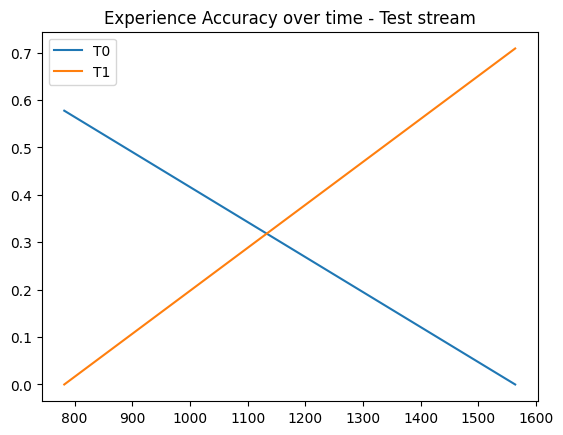

In [11]:
import matplotlib.pyplot as plt
allres = strategy.evaluator.get_all_metrics()
for tid in range(2):
    mname = f"Top1_Acc_Exp/eval_phase/test_stream/Task00{tid}/Exp00{tid}"
    print(mname)
    plt.plot(allres[mname][0], allres[mname][1], label=f"T{tid}")
plt.legend()
plt.title("Experience Accuracy over time - Test stream")

# Training - MultiTask

The previous baseline was not using task labels. What happens if you finetune the model but you use a multi-head classifier?

We are going to use Avalanche for the implementation. We are going to look at the implementation in a future lecture.

In [12]:
from avalanche.training import Naive
from avalanche.models import as_multitask

# a benchmark with task labels
benchmark = SplitCIFAR10(n_experiences=2, return_task_id=True)

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)

# change the classifier to a multi-head classifier
model = as_multitask(model, "linear")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# naive is the naive finetuning, the same training method that we used above
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)
strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=1,
    evaluator=eval_plugin
)

for exp in benchmark.train_stream:
    strategy.train(exp)
    strategy.eval(benchmark.test_stream)

Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [03:33<00:00,  3.67it/s]
Epoch 0 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 157/157 [00:15<00:00, 10.18it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6278
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 157/157 [00:14<00:00, 10.66it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.2000
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task001 = 0.4139
-- >> Start of training phase << --
100%|██████████| 782/782 [03:29<00:00,  3.73it/s]
Epoch 0 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) fro

Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001
Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002
Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003
Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004


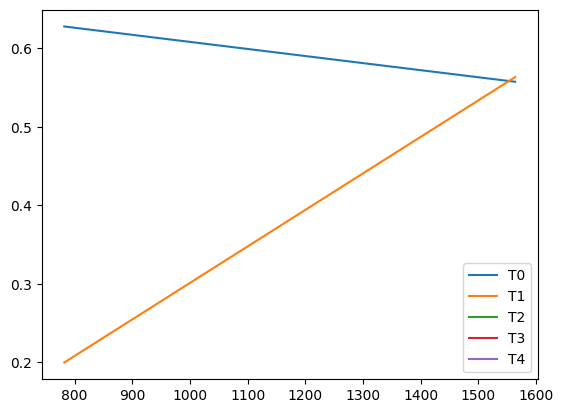

In [13]:
import matplotlib.pyplot as plt
allres = strategy.evaluator.get_all_metrics()
for tid in range(5):
    mname = f"Top1_Acc_Exp/eval_phase/test_stream/Task00{tid}/Exp00{tid}"
    print(mname)
    plt.plot(allres[mname][0], allres[mname][1], label=f"T{tid}")
plt.legend()

What's happening here? Why do we have forgetting even though we are using task labels?

# Training - Cumulative
Cumulative trains each step on all the data seen up to now:
- t=0 -> train on Exp0
- t=1 -> train on Exp0 U Exp1, starting from the previous model

...

In [14]:
from avalanche.training import Cumulative

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)
strategy = Cumulative(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=1
)

for exp in benchmark.train_stream:
    strategy.train(exp)
    strategy.eval(benchmark.test_stream)

-- >> Start of training phase << --
100%|██████████| 782/782 [03:12<00:00,  4.07it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0861
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5692
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 157/157 [00:12<00:00, 12.19it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0413
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5972
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 157/157 [00:13<00:00, 11.84it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task001/Exp001 = 11.2200
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task001 = 6.1306
	Top1_Acc_Stream/eval_phase/test_stream/Task001 = 0.2986
-- >> St

Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001


Text(0.5, 1.0, 'Experience Accuracy over time - Test stream')

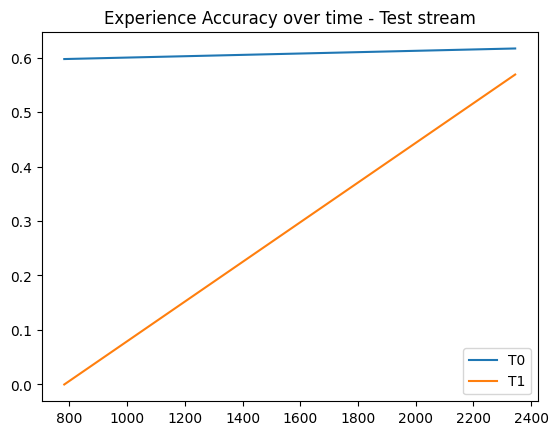

In [15]:
allres = strategy.evaluator.get_all_metrics()
for tid in range(2):
    mname = f"Top1_Acc_Exp/eval_phase/test_stream/Task00{tid}/Exp00{tid}"
    print(mname)
    plt.plot(allres[mname][0], allres[mname][1], label=f"T{tid}")
plt.legend()
plt.title("Experience Accuracy over time - Test stream")

# Training - Joint

Just as a baseline we can also train on all the data at once. This is the standard offline training.

In [ ]:
from avalanche.training import JointTraining

benchmark = SplitCIFAR10(n_experiences=2, return_task_id=True)

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=100)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

strategy = JointTraining(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_mb_size=32, train_epochs=1
)

# we train on the entire stream all at once
# internally, it's going to concatenate all the batches and train on the joint data
strategy.train(benchmark.train_stream)

Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
 30%|███       | 470/1563 [01:28<03:31,  5.17it/s]

In [ ]:
strategy.eval(benchmark.test_stream)

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 113.24it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.3087
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5196
-- Starting eval on experience 1 (Task 1) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 111.55it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task001/Exp001 = 1.3683
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.5224
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task001 = 1.3385
	Top1_Acc_Stream/eval_phase/test_stre

{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.41672,
 'Loss_Epoch/train_phase/train_stream/Task000': 1.615275440940857,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.5196,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 1.3087145668918412,
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.5224,
 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 1.3683192514576483,
 'Top1_Acc_Stream/eval_phase/test_stream/Task001': 0.521,
 'Loss_Stream/eval_phase/test_stream/Task001': 1.3385169091747449}

# Exercises
You can implement the algorithms in pure pytorch starting from the `avl_standalone` notebook and the previous notebooks (the finetuning exercises).
- Naive finetuning
- Multi-head with task labels. You can use Avalanche [MultiHeadClassifier](https://avalanche-api.continualai.org/en/v0.5.0/generated/avalanche.models.MultiHeadClassifier.html#avalanche.models.MultiHeadClassifier) or implement it yourself.
- Cumulative training

After you have some baselines you can try some simple experiments:
- try to measure the forgetting by monitoring how the accuracy on each task is changing over time
- can you identify some of the causes of forgetting? Is it:
    - a high number of epochs?
    - a high learning rate?
    - the model architecture (width, depth, batch-norm, ...)?
    - the type of drift?
- try to repeat the experiments with a new type of drift. Each experience contains the same classes but with new instances. For example, you can split CIFAR10 in a class-balanced way or use [PermutedMNIST](https://avalanche-api.continualai.org/en/v0.5.0/generated/avalanche.benchmarks.classic.PermutedMNIST.html#avalanche.benchmarks.classic.PermutedMNIST), which permutes the images differently at every step (you need to use a feedforward net in this case). 
- what happens if you revisit the stream multiple times? you can try to repeat the stream multiple times in the multi-head finetuning example